In [1]:
from npl.descriptors import ExtendedTopologicalFeaturesClassifier
from npl.monte_carlo.monte_carlo_etop import run_monte_carlo
from npl.core import Nanoparticle
from npl.calculators import EMTCalculator
from npl.calculators import BayesianRRCalculator
import matplotlib.pyplot as plt
from npl.utils.utils import plot_cummulative_success_rate, plot_learning_curves, plot_elemental_concentration_per_layer
from ase.visualize.plot import plot_atoms

In [2]:
def create_octahedron_training_set(n_particles, height, trunc, stoichiometry, descriptor_calculator):
    emt_calculator = EMTCalculator(fmax=0.2)

    training_set = []
    for i in range(n_particles):
        p = Nanoparticle()
        p.truncated_octahedron(height, trunc, stoichiometry)
        emt_calculator.compute_energy(p)
        descriptor_calculator.compute_feature_vector(p)
        training_set.append(p)

    return training_set

In [3]:
stoichiometry = {'Pd':0.33, 'Au' : 0.33, 'Cu' : 0.34}
etop = ExtendedTopologicalFeaturesClassifier(list(stoichiometry.keys()))

In [4]:
training_set = create_octahedron_training_set(150, 5, 1, stoichiometry, etop)

In [5]:
calculator = BayesianRRCalculator(etop.get_feature_key())
calculator.fit(training_set, 'EMT', validation_set=0.1)

Mean Absolute error 1.4994 meV/atom
Root Mean Square error 1.8952 meV/atom


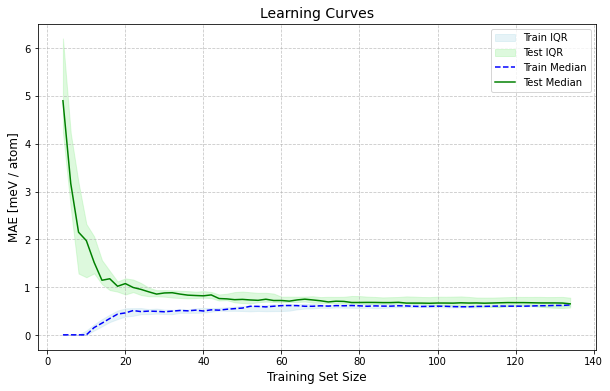

In [6]:
X = [p.get_feature_vector(etop.get_feature_key()) for p in training_set]
y = [p.get_energy('EMT') for p in training_set]
n_atoms = training_set[0].get_n_atoms()
plot_learning_curves(X, y, n_atoms,
                     calculator.ridge, 
                     n_splits=10, train_sizes=range(4, int(len(training_set)*0.9), 2))

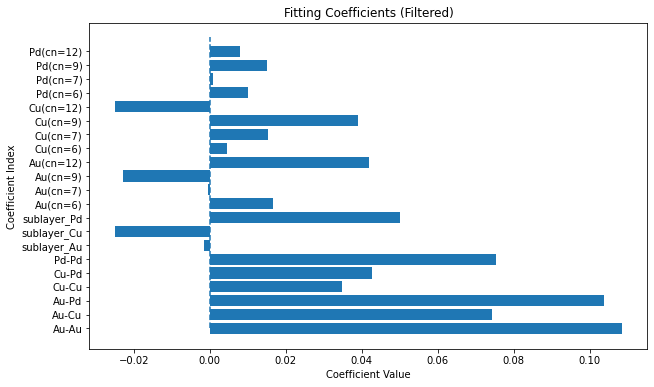

In [7]:
coefficients = calculator.get_coefficients()
feature_names = etop.get_feature_labels()
# Filter coefficients that are not super close to 0
threshold = 1e-16
filtered_indices = [i for i, coef in enumerate(coefficients) if abs(coef) > threshold]
filtered_coefficients = [coefficients[i] for i in filtered_indices]
filtered_feature_names = [feature_names[i] for i in filtered_indices]

# Plot the filtered coefficients
plt.figure(figsize=(10, 6))
plt.barh(range(len(filtered_coefficients)), filtered_coefficients)
plt.vlines(0, 0, len(filtered_coefficients), linestyles='dashed')
plt.yticks(range(len(filtered_coefficients)), filtered_feature_names)
plt.ylabel('Coefficient Index')
plt.xlabel('Coefficient Value')
plt.title('Fitting Coefficients (Filtered)')
plt.show()

In [16]:
def create_start_particle(height, trunc, stoichiometry):
    start_particle = Nanoparticle()
    start_particle.truncated_octahedron(height, trunc, stoichiometry)
    return start_particle

beta, max_steps = 300, 10000

steps_MC, energies_MC = [], []
for _ in range(10):
    start_particle = create_start_particle(6, 2, stoichiometry)
    [best_particle, accepted_energies] = run_monte_carlo(beta, max_steps, start_particle, calculator, etop)
    min_energy, min_step = min(accepted_energies, key=lambda x: x[0])
    energies_MC.append(min_energy)
    steps_MC.append(min_step)
    if min_energy <= min(energies_MC):
        global_minimum = best_particle

Step: 2000
Lowest energy: 32.08129284357431
Step: 4000
Lowest energy: 31.97450172484438
Step: 6000
Lowest energy: 31.97450172484438
Step: 8000
Lowest energy: 31.97450172484438
Step: 10000
Lowest energy: 31.97450172484438
Step: 12000
Lowest energy: 31.97450172484438
Step: 2000
Lowest energy: 32.04692495101063
Step: 4000
Lowest energy: 31.998115662797495
Step: 6000
Lowest energy: 31.985704986991863
Step: 8000
Lowest energy: 31.974731959158753
Step: 10000
Lowest energy: 31.974731959158753
Step: 12000
Lowest energy: 31.974731959158753
Step: 14000
Lowest energy: 31.974731959158753
Step: 16000
Lowest energy: 31.968468378325746
Step: 18000
Lowest energy: 31.965135949347854
Step: 20000
Lowest energy: 31.95098611682291
Step: 22000
Lowest energy: 31.95098611682291
Step: 24000
Lowest energy: 31.95098611682291
Step: 26000
Lowest energy: 31.95098611682291
Step: 28000
Lowest energy: 31.95098611682291
Step: 2000
Lowest energy: 32.097490055067425
Step: 4000
Lowest energy: 31.985665790206134
Step: 6000

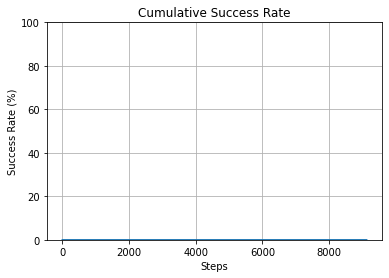

In [13]:
plot_cummulative_success_rate(energies_MC, steps_MC)

(0.0, 22.95895946097198, 0.0, 15.203999999999999)

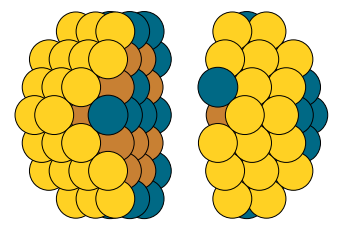

In [14]:
from ase.data import colors

atoms = global_minimum.get_ase_atoms()
atoms.center()
atoms1 = atoms[[a.index for a in atoms if a.position[2] < atoms.get_cell()[2][2]/2 +1.0]]
atoms2 = atoms[[a.index for a in atoms if a.position[2] > atoms.get_cell()[2][2]/2 +1.0]]
l = 3
atoms1.translate(( 0., 0.,-l))
atoms2.translate(( 0., 0.,l))
atoms = atoms1 + atoms2

plot_atoms(atoms, rotation=('0x,75y,0z'))
plt.axis('off')

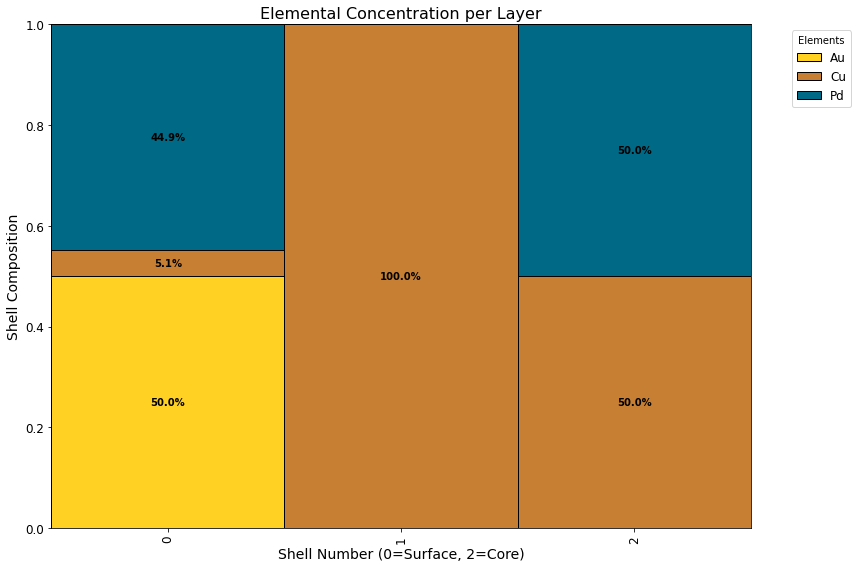

In [15]:
plot_elemental_concentration_per_layer(global_minimum)